In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms.functional as tf
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tqdm.notebook as tq
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


### UNET MODEL

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # down part of Unet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        # up part of Unet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = tf.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return  self.final_conv(x)




In [3]:
def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert  preds.shape == x.shape

test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


### Helper Functions

In [4]:
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,)

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform)

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False)

    return train_loader, val_loader

def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

def resize_it(x):
    if x.shape != (160, 240):
        x = cv2.resize(x, dsize=(160, 240), interpolation=cv2.INTER_LINEAR)
    return x


###  Train DataSet


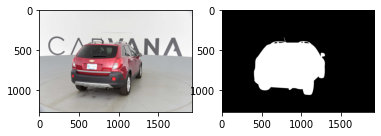

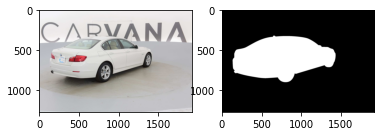

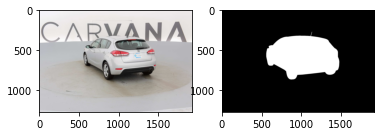

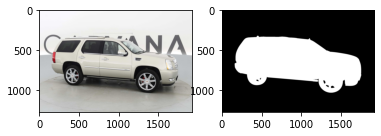

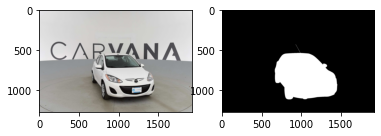

In [5]:
image_names = list(os.listdir('/content/data/train/'))

for i in range(5):
  random = np.random.randint(5040)  
  img_example = Image.open("/content/data/train/" + image_names[random])
  mask_example = Image.open("/content/data/train_masks/" + image_names[random].replace(".jpg", "_mask.gif"))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(img_example)
  axarr[1].imshow(mask_example)
  plt.show()

In [6]:

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask[mask==255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        return image, mask


In [7]:
# Hyperparameters 
train_on_gpu = torch.cuda.is_available()
LEARNING_RATE = 5e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 5
NUM_WORKERS = 2
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 240
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "/content/data/train/"
TRAIN_MASK_DIR = "/content/data/train_masks/"
VAL_IMG_DIR = "/content/data/val/"
VAL_MASK_DIR = "/content/data/val_masks/"

In [8]:

train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ])
    
   
train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

### TRAINING

In [9]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

In [10]:

train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf 
for epoch in range(1, NUM_EPOCHS+1):

    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    # train the model #
    model.train()
    bar = tq.tqdm(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        data = data.to(device=DEVICE)
        target = target.float().unsqueeze(1).to(device=DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})

    # validate the model #

    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq.tqdm(val_loader, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            data =  data.to(device=DEVICE)
            target = target.float().unsqueeze(1).to(device=DEVICE)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu(),threshold=0.5).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    dice_score = dice_score/len(val_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)


Epoch: 1  Training Loss: 0.251720  Validation Loss: 0.182215 Dice Score: 0.973983
Validation loss decreased (inf --> 0.182215).  Saving model ...



Epoch: 2  Training Loss: 0.158899  Validation Loss: 0.133018 Dice Score: 0.983287
Validation loss decreased (0.182215 --> 0.133018).  Saving model ...



Epoch: 3  Training Loss: 0.117532  Validation Loss: 0.100886 Dice Score: 0.985982
Validation loss decreased (0.133018 --> 0.100886).  Saving model ...



Epoch: 4  Training Loss: 0.090943  Validation Loss: 0.076977 Dice Score: 0.986636
Validation loss decreased (0.100886 --> 0.076977).  Saving model ...



Epoch: 5  Training Loss: 0.070726  Validation Loss: 0.060587 Dice Score: 0.988325
Validation loss decreased (0.076977 --> 0.060587).  Saving model ...


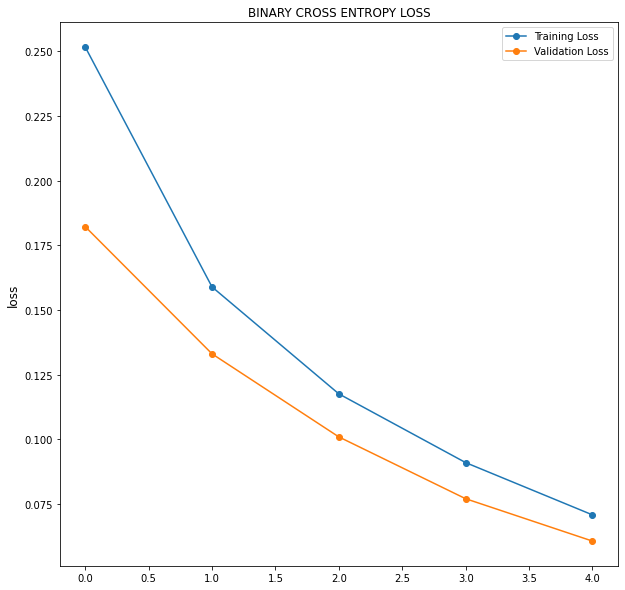

In [11]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.title("BINARY CROSS ENTROPY LOSS")
plt.ylabel('loss', fontsize=12)
plt.legend()
plt.show()

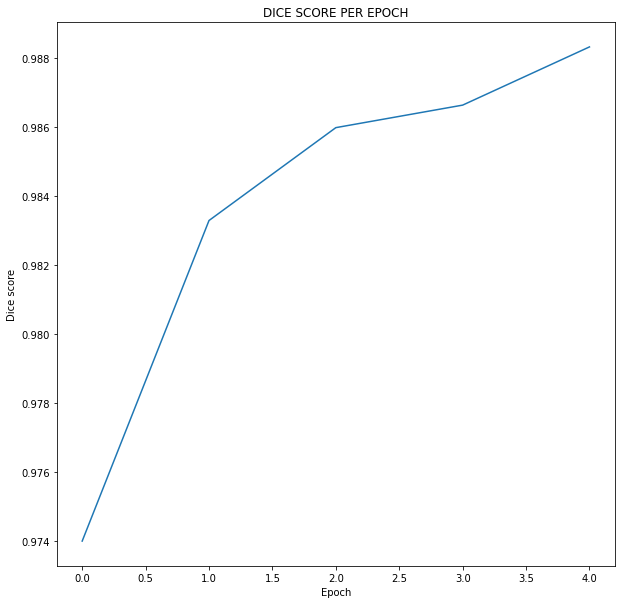

In [12]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.title('DICE SCORE PER EPOCH')
plt.ylabel('Dice score')
plt.xlabel('Epoch')
plt.show()

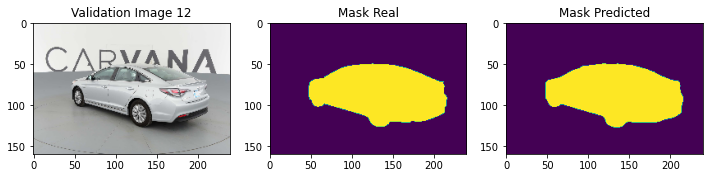

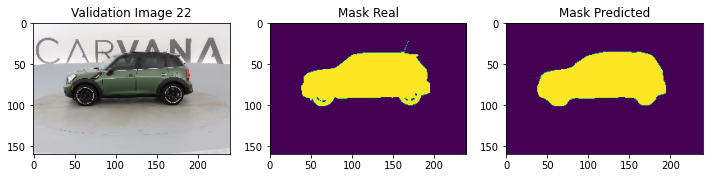

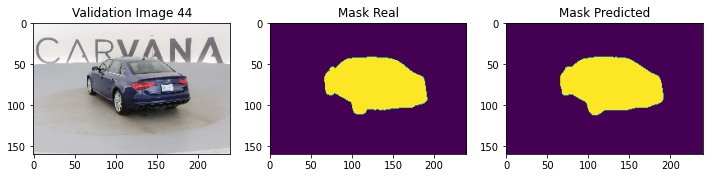

In [13]:
for i, (data, target) in enumerate(val_loader):
    data = data.cuda()
    random = np.random.randint(16)
    output = torch.sigmoid(model(data))
    pred = (output[random] > 0.5).float()
    pred  = pred.cpu().detach().numpy()
    image  = data[random].cpu().detach().numpy()
    mask   = target[random].cpu().detach().numpy()
    pred = pred.reshape((160,240))
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8')
    f, ax = plt.subplots(1,3, figsize=(12,10))
    ax[0].set_title("Validation Image {}".format(random + (16*i)))
    ax[1].set_title("Mask Real")
    ax[2].set_title("Mask Predicted")
    ax[0].imshow(image_vis)
    ax[1].imshow(mask)
    ax[2].imshow(pred)   
   